In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, make_scorer

In [50]:
PATH_DATA = '../data/data/'
PATH_IMAGES = '../assets/images/confusion/'
PATH_RESULTS = '../results/'

## Loading the data

In [74]:
# training set
train = pd.read_csv(PATH_DATA + "CRC_3200_train.csv")
X_train = train[['num_discourse', 'num_modals']].copy()
y_train = train['tag'].copy()

In [71]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   num_discourse  3200 non-null   int64
 1   num_modals     3200 non-null   int64
dtypes: int64(2)
memory usage: 50.1 KB


In [73]:
# test set (CRC)
test_CRC = pd.read_csv(PATH_DATA + "CRC_800_test.csv")
X_test_CRC = test_CRC[['num_discourse', 'num_modals']].copy()
y_test_CRC = test_CRC['tag'].copy()

In [23]:
# test set (C3)
test_c3 = pd.read_csv(PATH_DATA + "C3_12000.csv")
X_test_c3 = test_c3[['named_entities']].copy()
y_test_bin_c3 = test_c3['bin_tag'].copy()

In [24]:
# test set (YNACC)
test_ynacc = pd.read_csv(PATH_DATA + "YNACC.csv")
X_test_ynacc = test_ynacc[['named_entities']].copy()
X_test_ynacc.fillna(0, inplace=True)
y_test_bin_ynacc = test_ynacc['bin_tag'].copy()

## Gradient Boosting

In [85]:
clf = GradientBoostingClassifier(n_estimators=300,
                                  learning_rate=0.03,
                                  max_depth=8,
                                  validation_fraction=0.1,
                                  n_iter_no_change=5, tol=0.005,
                                  random_state=200,
                                  verbose=1)

### All features - Multiclass

In [76]:
trans = ColumnTransformer(transformers=[
            #('review', TfidfVectorizer(min_df=1, max_df=0.1, encoding='utf-8', ngram_range=(1,1)), 'text_review'),
            #('pos', TfidfVectorizer(encoding='utf-8', ngram_range=(1,1)), 'text_pos'),
            ],
                         remainder='passthrough')

In [77]:
pipeline = Pipeline([
    ('union', trans)
])

In [82]:
X_train_fitted = pipeline.fit_transform(X_train)
X_test_CRC_fitted = pipeline.transform(X_test_CRC)
#X_test_c3_fitted = pipeline.transform(X_test_c3)
#X_test_ynacc_fitted = pipeline.transform(X_test_ynacc)

print('Size of the feature matrix for CRC:', X_test_CRC_fitted.shape)
#print('Size of the feature matrix for C3:', X_test_c3_fitted.shape)
#print('Size of the feature matrix for YNACC:', X_test_ynacc_fitted.shape)

Size of the feature matrix for CRC: (800, 2)


In [86]:
clf.fit(X_train_fitted, y_train)

      Iter       Train Loss   Remaining Time 
         1        3645.7741            4.65s
         2        3608.9752            4.64s
         3        3575.6136            4.88s
         4        3545.1080            4.99s
         5        3516.9233            4.85s
         6        3490.8848            4.70s
         7        3466.6802            4.73s
         8        3444.1702            4.60s
         9        3423.1618            4.47s
        10        3403.5305            4.38s
        20        3261.3255            4.15s
        30        3178.8544            3.77s
        40        3126.6246            3.65s
        50        3093.3239            3.52s
        60        3072.3418            3.41s
        70        3058.1252            3.19s
        80        3048.1525            3.04s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.03, loss='deviance', max_depth=8,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=5, presort='deprecated',
                           random_state=200, subsample=1.0, tol=0.005,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

Accuracy: 0.4925
F1 Score: 0.4570060763205325
              precision    recall  f1-score   support

           0       0.09      0.01      0.02       108
           1       0.51      0.62      0.56       280
           2       0.47      0.61      0.53       300
           3       0.61      0.33      0.43       112

    accuracy                           0.49       800
   macro avg       0.42      0.39      0.38       800
weighted avg       0.45      0.49      0.46       800



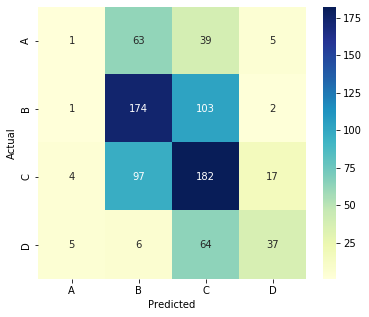

In [87]:
y_pred = clf.predict(X_test_CRC_fitted)
print("Accuracy:", accuracy_score(y_test_CRC, y_pred))
print("F1 Score:", f1_score(y_test_CRC, y_pred, average='weighted'))
print(classification_report(y_test_CRC, y_pred))
report = classification_report(y_test_CRC, y_pred, output_dict=True)
#pd.DataFrame(report).transpose().to_csv(PATH_RESULTS+'bin-GBM-C3-entities.csv', index=False)

conf_mat = confusion_matrix(y_test_CRC, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_xticklabels(['A', 'B', 'C', 'D'])
ax.set_yticklabels(['A', 'B', 'C', 'D'])
#plt.savefig(PATH_IMAGES+'bin-GBM-CRC-all.png', bbox_inches='tight')
plt.show()

In [59]:
# Misclassified examples for GBM with all features in multiclass setting

#for i, j, k in zip(X_test_CRC.text_review, y_test_CRC, y_pred):
#    if k-j > 1 or j-k > 1:
#        print("REVIEW:", i, "GOLD", j, "PREDICTED:", k, "\n")

REVIEW: why people think that they need these has always been a mystery ... as if sony microsoft nintendo do not stress test their systems and efficiently tune the stock cooling fansthis is clearly a product that nobody really needs GOLD 0 PREDICTED: 2 

REVIEW: bought the ir3bu model a couple years ago and has been returned twicw for repair and now the menu system is in chinese which is not a problem as it is broke down again i would spend the three hundred on another scout camera before buying another of these GOLD 0 PREDICTED: 2 

REVIEW: sorry billy but more compilations like this are only driving fans away there is absolutely nothing here that has not already been rehashed ten times over yet another horrendous disappointment GOLD 0 PREDICTED: 2 

REVIEW: the heads are carbide but the shanks are soft steel the shank diameter is 3mm not 1/8 as advertised the 3mm shank will not chuck up in a proper 1/8 die grinder it may chuck up in a cheep electric dremel tool or equivalent but not 